In [ ]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/pose_dataset_aug.zip"

In [ ]:
! cp "/content/drive/MyDrive/Colab Notebooks/helper_functions.py" "helper_functions.py"

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import LSTM, Dense, GRU,Dropout, concatenate, Conv2D, MaxPooling2D, TimeDistributed, GlobalAveragePooling2D
from helper_functions import make_confusion_matrix, getPrescisionRecallF1


SEED = 42
BATCH_SIZE = 14
FRAME_WIDTH = 640
FRAME_HIGHT = 480
epochs = 50
length = 20
IMG_SIZE = 128
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
root_dir = "pose_dataset_aug"
pre_dir = "aug_seg_rgb_resize"
split_dir_dict_path="/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/split_dir_dict.npy"

In [ ]:
class_names = sorted([x.split(f"{root_dir}/")[-1] for x in glob(f"{root_dir}/*")])
class_dict = {x:i for i,x in enumerate(class_names)}
num_classes = len(class_names)
num_classes, class_names, class_dict

(7,
 ['Clapping',
  'Meet and Split',
  'Sitting',
  'Standing Still',
  'Walking',
  'Walking While Reading Book',
  'Walking While Using Phone'],
 {'Clapping': 0,
  'Meet and Split': 1,
  'Sitting': 2,
  'Standing Still': 3,
  'Walking': 4,
  'Walking While Reading Book': 5,
  'Walking While Using Phone': 6})

In [ ]:
from collections import defaultdict


def get_train_test_split(root_dir, class_names,split_dir_dict_path):

    if os.path.exists(split_dir_dict_path):

        return np.load(split_dir_dict_path, allow_pickle=True).item()

    split_dir_dict = {

        "train": [],

        "test": [],

    }

    for class_name in class_names:

        img_dirs = glob(f"{root_dir}/{class_name}/*")
        img_dirs_dict = defaultdict(list)
        for img_dir in img_dirs:
            key = img_dir.split("/")[-1].split("_")[0]
            img_dirs_dict[key].append(img_dir)

        # print(img_dirs_dict)
        np.random.seed(42)
        keys = list(img_dirs_dict.keys())
        # print(keys)
        np.random.shuffle(keys)

        train_keys, test_keys = train_test_split(keys, test_size=0.2)

        for train_key in train_keys:
            split_dir_dict["train"].extend(img_dirs_dict[train_key])
        for test_key in test_keys:
            split_dir_dict["test"].extend(img_dirs_dict[test_key])

    np.random.seed(42)

    np.random.shuffle(split_dir_dict["train"])

    np.random.shuffle(split_dir_dict["test"])

    np.save(split_dir_dict_path, split_dir_dict)

    return np.load(split_dir_dict_path, allow_pickle=True).item()


In [ ]:
split_dir_dict = get_train_test_split(root_dir, class_names, split_dir_dict_path)

In [ ]:
train_dirs = split_dir_dict["train"]
test_dirs = split_dir_dict["test"]
len(train_dirs), len(test_dirs)

(12404, 3178)

In [ ]:
test_dirs = [x for x in test_dirs if len(x.split("/")[-1].split("_")) ==1]
len(test_dirs)

227

In [ ]:
train_keyPoints_dirs = [x.replace(pre_dir, root_dir) for x in train_dirs]
test_keyPoints_dirs = [x.replace(pre_dir, root_dir) for x in test_dirs]
len(train_keyPoints_dirs), len(test_keyPoints_dirs), train_dirs[0], test_keyPoints_dirs[0]

(12404,
 227,
 'aug_seg_rgb_resize/Meet and Split/00135_rotation_20',
 'pose_dataset_aug/Walking While Reading Book/00115')

In [ ]:
def get_labels(image_dirs):
    labels = []
    for x in image_dirs:
        labels.append(class_dict[x.split("/")[-2]])
    return np.array(labels)

In [ ]:
def load_keypoints(npy_dirs):
    npy_datas = []
    for x in tqdm(npy_dirs):
        npy_paths = glob(f"{x}/*")
        npy_paths = np.array(sorted(npy_paths))
        index = np.round(np.linspace(0,len(npy_paths)-1,length))
        index = index.astype(np.int8)
        npy_paths = npy_paths[index]
        npy_data = []
        for y in npy_paths:
            data = np.load(y)
            data[:,:,0] /= FRAME_WIDTH
            data[:,:,1] /= FRAME_HIGHT
            npy_data.append(np.ravel(data))
        npy_datas.append(npy_data)
    return np.array(npy_datas, dtype=np.float32)

In [ ]:
train_labels = get_labels(train_keyPoints_dirs)
test_labels = get_labels(test_keyPoints_dirs)

train_keypoints_dataset = load_keypoints(train_keyPoints_dirs)
test_keypoints_dataset = load_keypoints(test_keyPoints_dirs)


  0%|          | 0/12404 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

In [ ]:
train_labels.shape, test_labels.shape, train_keypoints_dataset.shape, test_keypoints_dataset.shape

((12404,), (227,), (12404, 20, 102), (227, 20, 102))

In [ ]:
y_train = tf.one_hot(train_labels, depth=num_classes)
y_test = tf.one_hot(test_labels, depth=num_classes)
y_train.shape, y_test.shape

(TensorShape([12404, 7]), TensorShape([227, 7]))

In [ ]:
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)

In [ ]:
train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
tf.random.set_seed(SEED)

# Define the keypoint model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=train_keypoints_dataset.shape[1:]))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation="softmax"))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


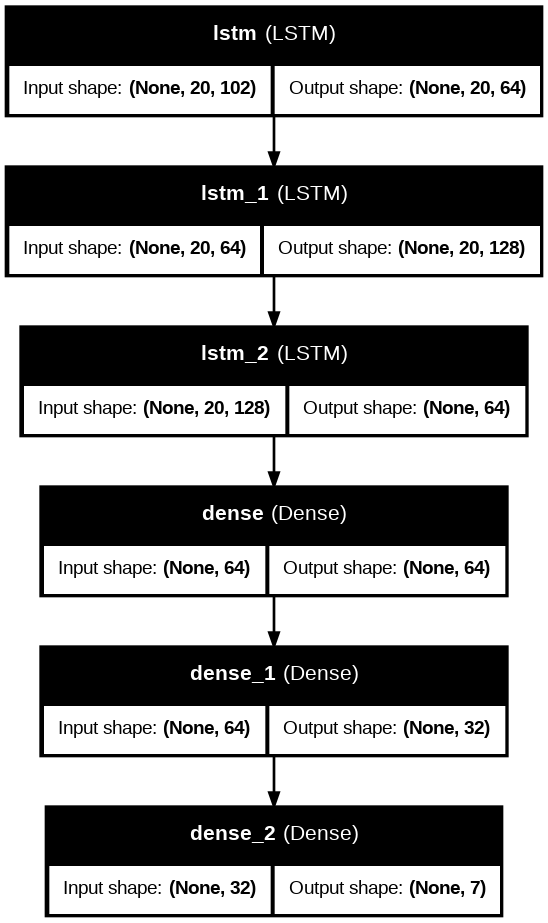

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
gdrive_Path = "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition"
checkPointName = "Key_CheckPoint"

# Best model
best_checkpoint_path = f"{gdrive_Path}/{checkPointName}/model_best/best_model.keras"
best_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    best_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True
)

# Every epoch model
checkpoint_path = f"{gdrive_Path}/{checkPointName}/model/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path+'model_{epoch:02d}.keras',
    save_freq='epoch'
)

# Reduce learning rate
reduce_callback =  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

# History
history_path = f"{gdrive_Path}/{checkPointName}/history.txt"
save_history_callback = tf.keras.callbacks.CSVLogger(history_path, append=True)
os.makedirs(os.path.dirname(history_path), exist_ok=True)



In [ ]:
save_model_paths = glob(f'{checkpoint_path}/*.keras')
save_model_paths = sorted(save_model_paths)

save_model_paths

[]

In [ ]:
initial_epoch = 0

if len(save_model_paths) == 0:
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(save_model_paths[-1])
    initial_epoch = int(save_model_paths[-1].split('_')[-1].split('.')[0])

initial_epoch

0

In [ ]:
# Assuming y_train and y_test are one-hot encoded labels
history = model.fit(
    x=train_keypoints_dataset,
    y=y_train,
    initial_epoch=initial_epoch,
    validation_data=(test_keypoints_dataset,y_test),
    epochs=epochs,
    batch_size=BATCH_SIZE,
    callbacks=[
        best_checkpoint_callback,
        checkpoint_callback,
        reduce_callback,
        save_history_callback
    ]
)

Epoch 1/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 0.4185 - loss: 1.3160 - val_accuracy: 0.5066 - val_loss: 0.9750 - learning_rate: 0.0010
Epoch 2/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.5411 - loss: 1.8271 - val_accuracy: 0.5639 - val_loss: 0.8870 - learning_rate: 0.0010
Epoch 3/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.5563 - loss: 0.8568 - val_accuracy: 0.6476 - val_loss: 0.7750 - learning_rate: 0.0010
Epoch 4/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.6273 - loss: 0.7652 - val_accuracy: 0.6652 - val_loss: 0.7631 - learning_rate: 0.0010
Epoch 5/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.6863 - loss: 0.6570 - val_accuracy: 0.7225 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 6/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7310 - loss: 0.5843 - val_accuracy: 0.7313 - val_loss: 0.7097 - learning_rate: 0.0010
Epoch 7/50
886/886 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.7848 - l

In [ ]:
def plot_loss_curves_history_path(history_path):
    """
    csv history
    """
    history = pd.read_csv(history_path)
    loss = history['loss']
    val_loss = history['val_loss']

    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    epochs = range(len(history['epoch']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

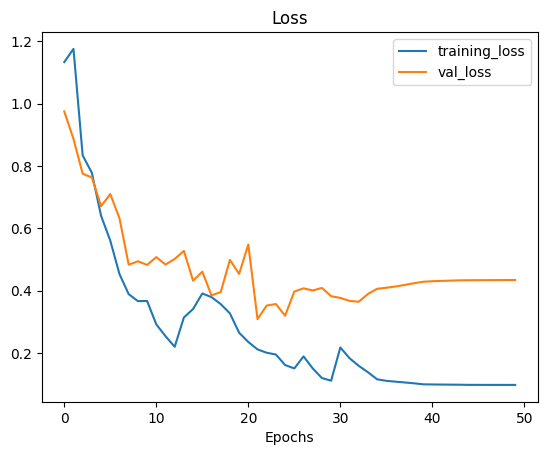

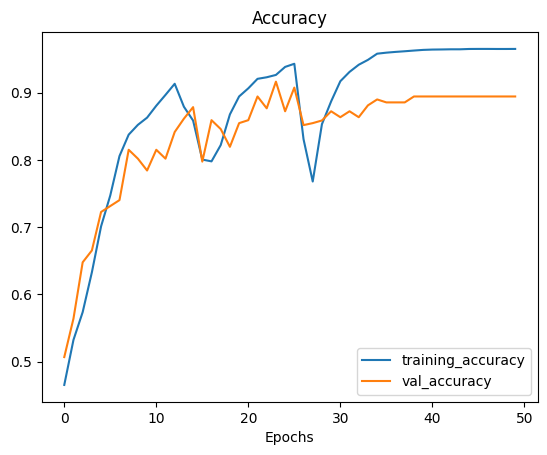

In [ ]:
plot_loss_curves_history_path(history_path)

In [ ]:
y_true_test = np.argmax(y_test, axis=-1)
y_pred_test = model.predict(test_keypoints_dataset)
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true_test.shape, y_pred_test.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


((227,), (227,))

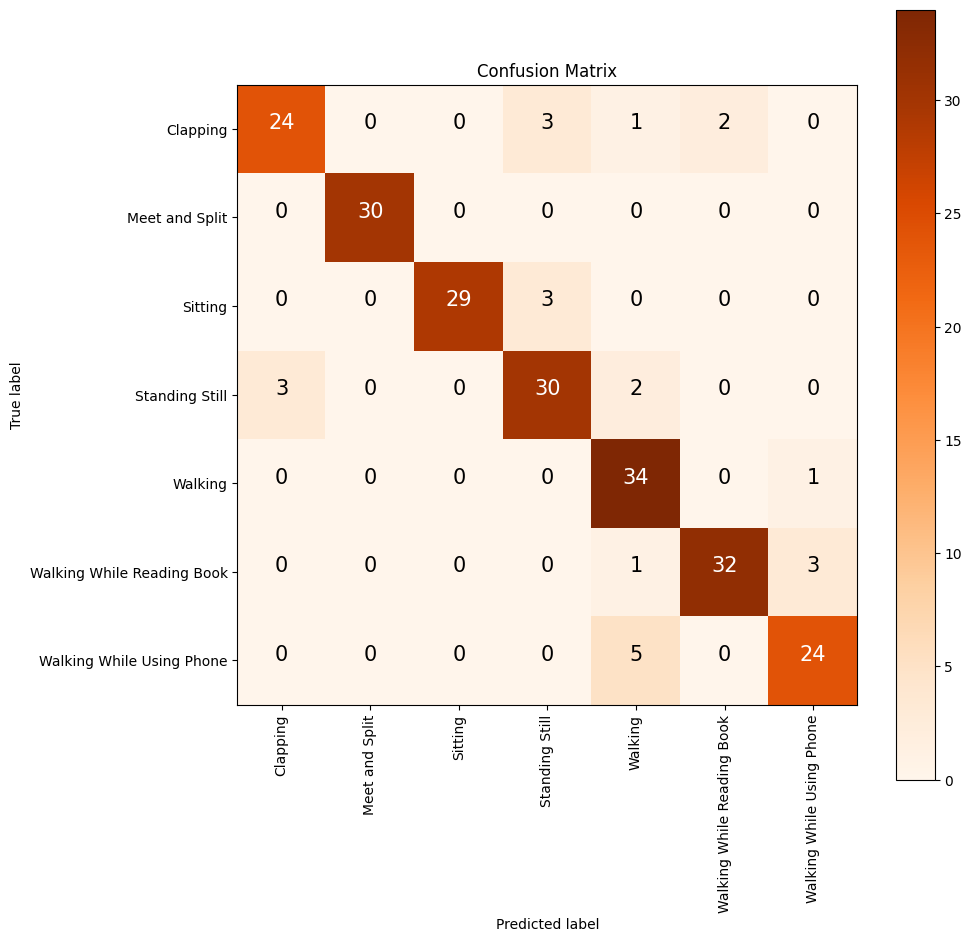

In [ ]:
make_confusion_matrix(y_true_test, y_pred_test, list(class_names))

In [ ]:
results = getPrescisionRecallF1(y_true_test, y_pred_test, class_names)
print(results)
with open(f"{gdrive_Path}/{checkPointName}/PrescisionRecallF1.txt", 'w') as file:
    file.write(results)

        Task           precision      recall        f1       Accuracy 
______________________________________________________________________
      Clapping           0.8889       0.8000       0.8421       0.8000  
   Meet and Split        1.0000       1.0000       1.0000       1.0000  
      Sitting            1.0000       0.9062       0.9508       0.9062  
   Standing Still        0.8333       0.8571       0.8451       0.8571  
      Walking            0.7907       0.9714       0.8718       0.9714  
Walking While Reading Book     0.9412       0.8889       0.9143       0.8889  
Walking While Using Phone     0.8571       0.8276       0.8421       0.8276  
______________________________________________________________________
      Average            0.9016       0.8930       0.8952       0.8943  
